These are the sequence of steps we will follow:

- open the classification JSON
- download and unzip the subject images
- find the consensus and agreement score/vote fraction per subject (is it a muon or not a muon)
- then analyze the results that we have

Let's first import our dependencies. We will load the data (which is in JSON format). We will use `numpy` for our basic array manipulation and analysis and some other useful utilities.

In [24]:
# for the data loading + analysis
import numpy as np
import json
# helpful utilities 
import glob
import pprint
import tqdm
# for plotting
import matplotlib.pyplot as plt

Now, we load the data and figure out what it looks like. The file is pretty big, so it will take a while to open.

In [9]:
with open('classifications.json', 'r') as infile:
    classification_data = np.asarray(json.load(infile))

In [75]:
print(len(classification_data))

1875616


Let's print out the first few entries to see what the data looks like:

In [11]:
pprint.pprint(classification_data[:5].tolist())

[{'classification_id': 235344035,
  'created_at': '2020-05-05 15:46:35 UTC',
  'data': 'No.',
  'expert': nan,
  'gold_standard': nan,
  'metadata': {'finished_at': '2020-05-05T15:46:34.931Z',
               'interventions': {'messageShown': False, 'opt_in': True},
               'live_project': True,
               'session': 'a247cfd40a121c31cec7bb9addc7412c3966ba8a475e311c7549087a3427471c',
               'source': 'api',
               'started_at': '2020-05-05T15:45:44.196Z',
               'subject_dimensions': [{'clientHeight': 689,
                                       'clientWidth': 689,
                                       'naturalHeight': 1008,
                                       'naturalWidth': 1008}],
               'subject_selection_state': {'already_seen': False,
                                           'finished_workflow': False,
                                           'retired': False,
                                           'selected_at': '2020-05-05T15

Each item in the list of classification is a dictionary. Here are some of the useful keys
- classification_id: this is a unique ID for each classification
- data: the output of the classification (when the user clicks "Yes!", it's a muon, or "No." when it's not)
- subject_ids: the unique ID of the subject (or the image)

There are some other keys that have useful data, but we will ignore those for now.

What we need to do next is to go through the subjects and figure out whether that subject was a muon. To do so, we need to loop over every subject, find all the classifications of that subject and then build a `consensus` and `agreement_score`. Consensus is the final "result" -- i.e. whether it is a muon or not, based on the volunteer classifications and agreement score is a metric that denotes how well all the volunteers who classified the image agree with each other. Simply put, the `consensus` is the modal value and `agreement_score` is the vote fraction for "Yes!".

For example, if there are 10 classifications and 8 of them picked "Yes!", then the consensus is that it is a muon and the agreement score is 0.8. Conversely if, say, only 4 of the 10 people picked "Yes!", then the consensus is that it is not a muon and the agreement score is 0.4. We call these final values the "aggregated result", so we need to a build a list of aggregated values per subject.

In [13]:
# get a list of subjects from the classification data (we will use this to filter our classification data by subject ID)
subject_list = np.asarray([classification['subject_ids'] for classification in classification_data])
# get a list of unique subjects in the data
subjects = np.unique(subject_list)

In [15]:
# let's create an array to hold this information 
# we will use a numpy array to hold three pieces of info: 
# the subject_id, agreement score and consensus (in that order)
aggregations = np.zeros((len(subjects), 3))

# we'll set an arbitrary threshold of 70% for the muon/non-muon cut
# (i.e. if 7/10 people say it's a muon, then it's a muon), if not then it's not a muon
threshold = 0.7

for i, subject in enumerate(tqdm.tqdm(subjects)):
    # find the classifications that correspond to this subject
    # we can use the filter function to get a generator that we can iterate over later
    classification_subset = classification_data[np.where(subject_list == subject)[0]]
    
    # now that we have our classifications, let's extract the value and aggregate the results
    extracts = []
    for classification in classification_subset:
        response = classification['data']
        
        # we need to convert the Yes! and No. to something numerical. Let's use 1 for Yes! and 0 for No.
        value = 1 if "Yes" in response else 0
        extracts.append(value)    
    extracts = np.asarray(extracts)
    
    # now we have our extracts, so we can calculate an agreement score
    counts_yes = sum(extracts == 1)
    counts_no = sum(extracts == 0)
    
    # calculate the agreement score and the consensus
    agreement_score = counts_yes/(counts_yes + counts_no)
    consensus = 1 if agreement_score > threshold else 0
    
    aggregations[i,:] = [subject, agreement_score, consensus]

100%|██████████████████████████████████████████████████████████████████████████████████████| 122467/122467 [01:36<00:00, 1272.58it/s]


Plot a histogram of the consenus showing the muons and non-muons

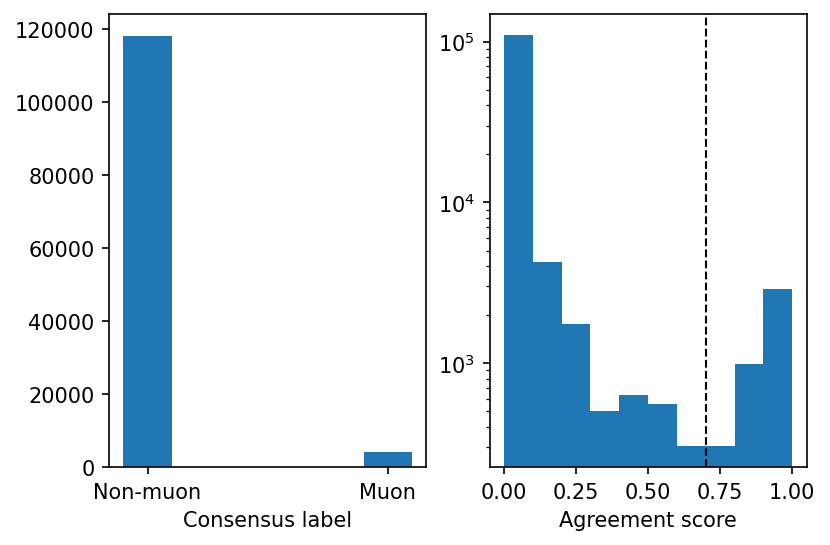

In [39]:
fig, axs = plt.subplots(1, 2, dpi=150, facecolor='white')
# plot the consensus
axs[0].hist(aggregations[:,2].astype(int), bins=[-0.1, 0.1, 0.9, 1.1])
axs[0].set_xlabel("Consensus label")
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(["Non-muon", "Muon"])

# and the agreement scores
axs[1].hist(aggregations[:,1])
axs[1].axvline(0.7, color='k', linestyle='dashed', linewidth=1)
axs[1].set_xlabel("Agreement score")
axs[1].set_yscale('log')

plt.show()

Let's plot out the different values. We can load up the subject images (from the provided tarball) and pull the corresponding images for each subject. 

First, let's plot our muons:

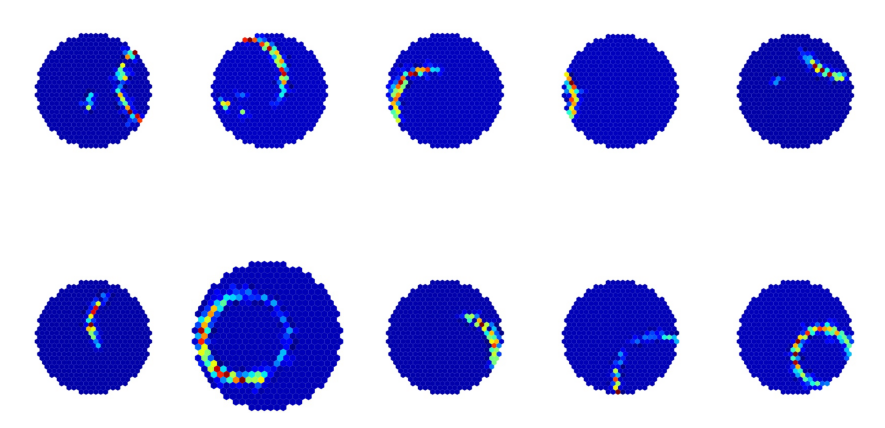

In [62]:
# get the aggregation data for the muons
muon_subset = aggregations[aggregations[:,1] > 0.7,:]

# get a random sample of 10 subjects
muon_random_subjects = muon_subset[np.random.randint(0, len(muon_subset), 10), 0].astype(int)

fig, axs = plt.subplots(2, 5, dpi=150, sharex=True, sharey=True, facecolor='white')
for subject, axi in zip(muon_random_subjects, axs.flatten()):
    subject_img = plt.imread(f'subject_images/{subject}.png')
    axi.imshow(subject_img)
    axi.axis('off')
    
plt.tight_layout()
plt.show()

Let's plot our confident non-muons next:

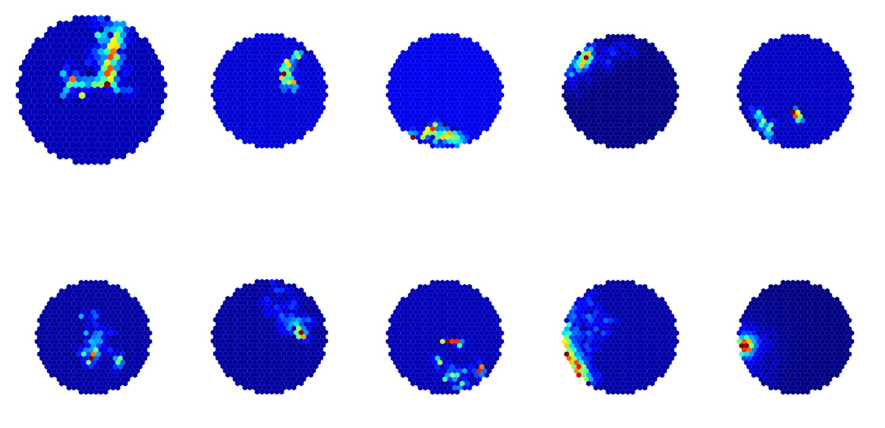

In [63]:
# get the aggregation data for the muons
non_muon_subset = aggregations[aggregations[:,1] < 0.2,:]

# get a random sample of 10 subjects
non_muon_random_subjects = non_muon_subset[np.random.randint(0, len(non_muon_subset), 10), 0].astype(int)

fig, axs = plt.subplots(2, 5, dpi=150, sharex=True, sharey=True, facecolor='white')
for subject, axi in zip(non_muon_random_subjects, axs.flatten()):
    subject_img = plt.imread(f'subject_images/{subject}.png')
    axi.imshow(subject_img)
    axi.axis('off')
    
plt.tight_layout()
plt.show()

Finally, let's plot some of the subjects which reside at the low confidence point (i.e. agreement score ~ 0.5)

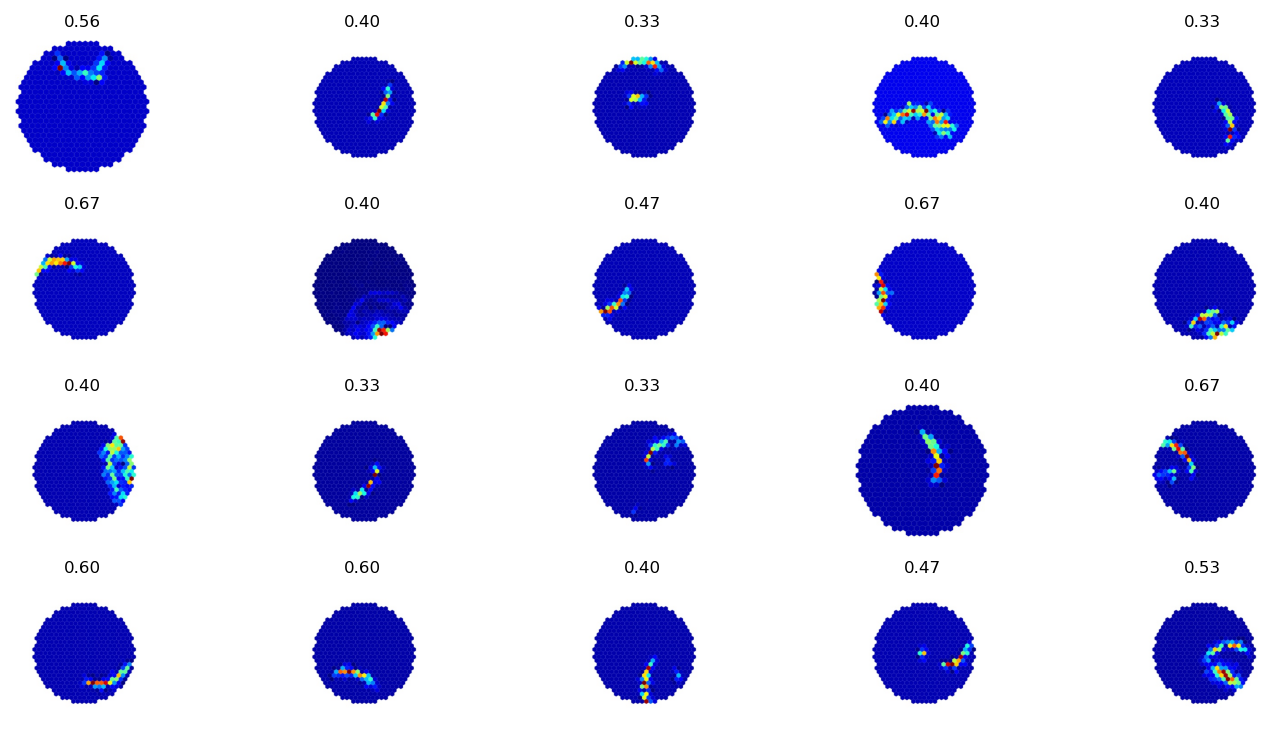

In [74]:
# get the aggregation data for the muons
confusing_subset = aggregations[(aggregations[:,1] > 0.3)&(aggregations[:,1] < 0.7),:]

# get a random sample of 10 subjects
confusing_random_subset = confusing_subset[np.random.randint(0, len(confusing_subset), 20), :]

fig, axs = plt.subplots(4, 5, dpi=150, figsize=(10, 5), sharex=True, sharey=True, facecolor='white')
for confusing_subject, axi in zip(confusing_random_subset, axs.flatten()):
    subject_img = plt.imread(f'subject_images/{int(confusing_subject[0])}.png')
    axi.imshow(subject_img)
    axi.axis('off')
    axi.set_title(f"{confusing_subject[1]:.2f}", fontsize=8)
    
plt.tight_layout()
plt.show()

Now, save out the data into a format that we can use later

In [61]:
np.save('aggregated_data.npy', aggregations)